#**說明**
此文件使用"SD.xlsx"作為輸入資料，此檔案位於"data"資料夾。並使用交叉驗證，第一場到最後一場事件輪流做為測試資料。測試結果的折線圖將輸出到"output"資料夾。訓練資料的預測值與觀測值資料將寫入"RES-train.xlsx"，測試資料的預測值與觀測值資料將寫入"RES-test.xlsx"，並輸出到"output"資料夾。

#**前置作業**

###引入模組

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import openpyxl
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Conv1D, LSTM, GRU, MaxPooling1D, Flatten, Dropout
from sklearn.svm import SVR
from keras.models import load_model

###定義路徑參數

In [ ]:
# 檔案、資料夾路徑參數
# GDRIVE_PATH = '/content/drive' # 雲端硬碟路徑
PROJECT_FOLDER = 'C:/Users/jason/Desktop/NSTC_Plan/Inundation_Forcasting/' # 專案資料夾的路徑
SD_FILE = PROJECT_FOLDER + 'data/SD.xlsx' # 資料檔案路徑
DATA_FOLDER = PROJECT_FOLDER + 'data/' # 存放資料的資料夾路徑
WEIGHTS_FOLDER = PROJECT_FOLDER + 'weights/' # 權重檔的資料夾路徑
OUTPUT_FOLDER = PROJECT_FOLDER + 'outputs/' # 輸出結果的資料夾路徑
HYDROGRAPH_FOLDER = PROJECT_FOLDER + 'outputs/Hydrographs/' # 歷線圖的資料夾路徑
SCATTER_PLOT_FOLDER = PROJECT_FOLDER + 'outputs/Scatter_Plots/' # 散點圖的資料夾路徑

###定義模型參數

In [ ]:
# 模型參數
epochs = 100 # 迭代次數(要讓模型看幾次訓練資料)
batch_size = 16 # 批次大小(每看多少筆資料更新一次權重)
learning_rate = 0.001 # 學習速率
loss_fn = 'mse' # 損失函數
dropout_rate = 0.2

###連接雲端硬碟

In [ ]:
# from google.colab import drive
# drive.mount(GDRIVE_PATH)

Mounted at /content/drive


#**副程式**

###資料處理工具

In [ ]:
# 載入資料
def load_data(path):
  wb = openpyxl.load_workbook(path, data_only=True)
  events = [wb[sheetname] for sheetname in wb.sheetnames]
  for i in range(len(events)):
    events[i] = pd.DataFrame(get_values(events[i]))
  return events

# 取得資料值並儲存為列表
def get_values(sheet):
  arr = [] 
  for row in sheet:
    temp = []  
    for column in row:
      temp.append(column.value)
    arr.append(temp)
  return arr

# 正規化資料(將資料範圍限縮在0~1之間，防止資料大小差異過大，影響模型訓練)
def normalize(data):
  normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
  return normalized_data

# 反正規化資料(將正規化的資料還原，用於結果呈現)
def denormalize(data, original):
  denormalized_data = data * (np.max(original) - np.min(original)) + np.min(original)
  return denormalized_data

# 分割訓練及測試資料
def split_data(X, Y, split_boundary):
  X_train = X[:split_boundary]
  Y_train = Y[:split_boundary]
  X_test = X[split_boundary:]
  Y_test = Y[split_boundary:]
  return X_train, Y_train, X_test, Y_test

# 產生可輸入模型的資料及標籤
def create_sequences(events):
  df = pd.concat(events, ignore_index=True)
  ref = df.iloc[:, :(len(df.columns)-1)] # 取得第一欄~倒數第二欄的資料為參考資料
  pred = df.iloc[:, (len(df.columns)-1)] # 以最後一欄的資料為目標資料

  X, Y = [], []
  num_data = len(ref)
  for i in range(num_data):
    seq = ref.iloc[i, :]
    label = pred[i]
    X.append(seq)
    Y.append(label)

  X, Y = np.array(X), np.array(Y)
  X = X.reshape(X.shape[0], X.shape[1], 1).astype('float32')
  Y = Y.reshape(Y.shape[0], 1).astype('float32')

  return X, Y

# 整理輸入資料順序以便輸入模型
def reorder_events(events, event_order):
  test_event = events[0] # 取得第一場事件資料為測試資料
  events = events[1:] # 第二場~最後一場
  events.append(test_event) # 將測試資料移到陣列尾端

  temp = event_order[0]
  event_order = event_order[1:]
  event_order.append(temp)

  boundary = []
  num_events = len(events)
  for i in range(num_events):
    boundary.append(sum([len(events[j]) for j in range(i+1)]))
  split_boundary = boundary[-2] # 訓練與測試資料的分割邊界

  return events, event_order, boundary, split_boundary


###定義模型

###傳統方法

BPNN

In [ ]:
class My_BPNN():
  def __init__(self):
    self.name = 'BPNN'

  # 定義sigmoid函數
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  # 前向傳播函數
  def forward(self, X, W1, W2):
    hidden = self.sigmoid(np.dot(X, W1))
    output = self.sigmoid(np.dot(hidden, W2))
    return hidden, output

  # 反向傳播函數
  def backward(self, X_train, Y_train, output, hidden, W2):
    error_output = Y_train - output
    delta_output = error_output * output * (1 - output)
    error_hidden = np.dot(delta_output, W2.T)
    delta_hidden = error_hidden * hidden * (1 - hidden)
    dW2 = np.dot(hidden.T, delta_output)
    dW1 = np.dot(X_train.T, delta_hidden)
    return dW1, dW2

  # 訓練模型函數
  def train(self, X_train, Y_train):
    # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    num_input = X_train.shape[1]
    num_output = Y_train.shape[1]
    num_hidden = 3
    # 初始化權重
    W1 = np.random.randn(num_input, num_hidden)
    W2 = np.random.randn(num_hidden, num_output)
    # 迭代訓練
    for epoch in range(epochs):
      hidden, output = self.forward(X_train, W1, W2)
      dW1, dW2 = self.backward(X_train, Y_train, output, hidden, W2)
      W1 += learning_rate * dW1
      W2 += learning_rate * dW2
    return W1, W2

  # 測試模型函數
  def predict(self, X_test, W1, W2):
    # X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    _, Y_predict = self.forward(X_test, W1, W2)
    return Y_predict


SVM

In [ ]:
class My_SVM():
  def __init__(self):
    self.name = 'SVM'

  def create_model(self):
    model = SVR(kernel='linear', C=1)
    return model
  
  def train(self, model, X_train, Y_train):
    # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    model.fit(X_train, Y_train)
    return model


###新方法

CNN

In [ ]:
class My_CNN():
  def __init__(self):
    self.name = 'CNN'

  def create_model(self, steps, features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(steps, features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(features))
    return model

  def train(self, model, X_train, Y_train, X_test, Y_test, show_training_history=True):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_fn)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test)) # 以測試資料為驗證資料   
    if show_training_history:
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='val')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
    return model


LSTM

In [ ]:
class My_LSTM():
  def __init__(self):
    self.name = 'LSTM'

  def create_model(self, steps, features):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(steps, features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64))
    model.add(Dropout(dropout_rate))
    model.add(Dense(features))
    return model

  def train(self, model, X_train, Y_train, X_test, Y_test, show_training_history=True):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_fn)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test)) # 以測試資料為驗證資料   
    if show_training_history:
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='val')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
    return model


GRU

In [ ]:
class My_GRU():
  def __init__(self):
    self.name = 'GRU'

  def create_model(self, steps, features):
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(steps, features)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(64))
    model.add(Dropout(dropout_rate))
    model.add(Dense(features))
    return model

  def train(self, model, X_train, Y_train, X_test, Y_test, show_training_history=True):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_fn)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test)) # 以測試資料為驗證資料   
    if show_training_history:
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='val')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
    return model


###畫圖工具

In [ ]:
# # 畫折線圖
# def draw_hydrograph(obv, pred):
#   fig, ax = plt.subplots()  # Create subplots with a single subplot
#   ax.plot(obv, color='red', label='Observation')
#   ax.plot(pred, color='blue', label='Estimation')
#   ax.set_title('Hydrograph')
#   ax.set_xlabel('Time')
#   ax.set_ylabel('Depth')
#   ax.legend()
#   ax.grid()
#   plt.show()
#   return fig
  
# # 畫45度線圖
# def draw_scatter(obv, pred):
#   fig, ax = plt.subplots()  # Create subplots with a single subplot
#   ax.plot([0, 175], [0, 175], color="red", linewidth=1, linestyle='-')
#   ax.scatter(obv, pred, color='g', alpha=0.6)
#   ax.set_title('Scatter Plot')
#   ax.set_xlabel('Observation')
#   ax.set_ylabel('Estimation')
#   ax.grid()
#   plt.show()
#   return fig


#**主程式**

###讀取資料、定義所需列表

In [ ]:
events = load_data(SD_FILE) # 載入資料
num_events = len(events) # 事件數量

RES_train = [] # 用於儲存訓練資料的預測結果
RES_test = [] # 用於儲存測試資料的預測結果

boundaries = [] # 用於儲存事件分割邊界
event_order = list(range(1, num_events+1)) # 事件排列順序
event_orders = [] # 用於儲存每次訓練的事件排列順序


###訓練模型、產生圖表


[第 1/5 次訓練]
▶ 以第 2, 3, 4, 5 場事件為訓練資料，以第 1 場事件為測試資料

Epoch 1/100
16/16 [==============================] - 9s 20ms/step - loss: 0.1254 - val_loss: 0.0797
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0671 - val_loss: 0.0875
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0625 - val_loss: 0.0663
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0600 - val_loss: 0.0715
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.0704
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0544 - val_loss: 0.0647
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0529 - val_loss: 0.0535
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0474 - val_loss: 0.0473
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.0531
Epoch 10/100
16/16 [==============================] - 0

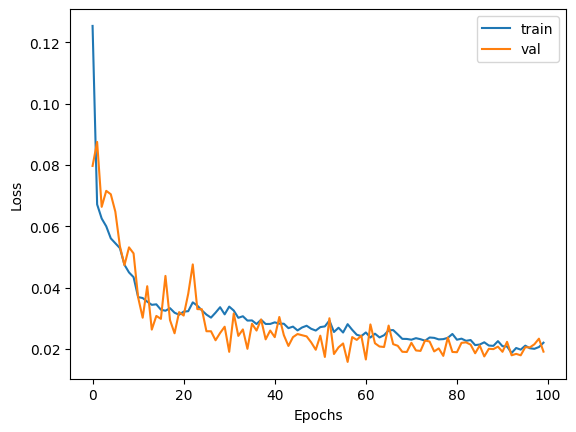

Training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/Weights_EV01.h5
2/2 [==============================] - 0s 4ms/step


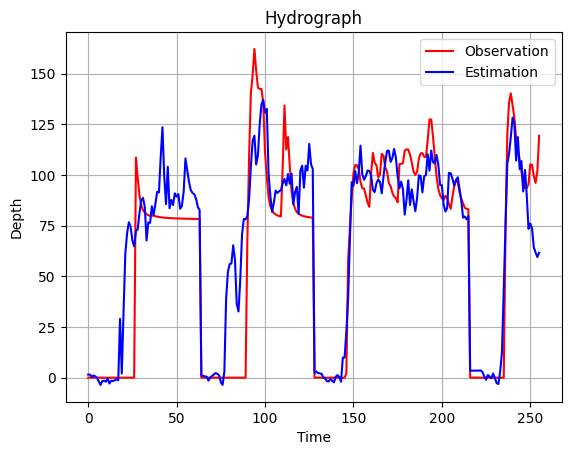

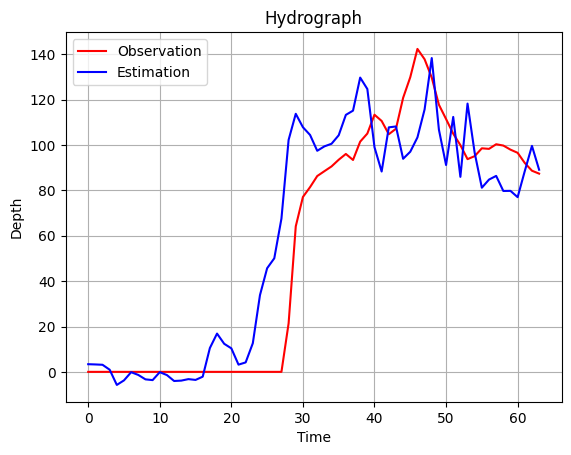

Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-train_EV01.png
Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-test_EV01.png


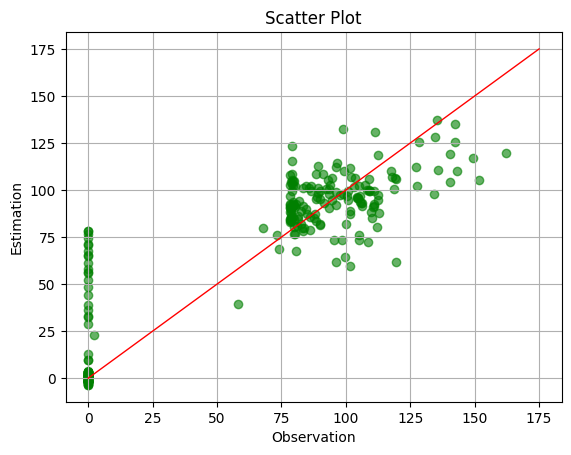

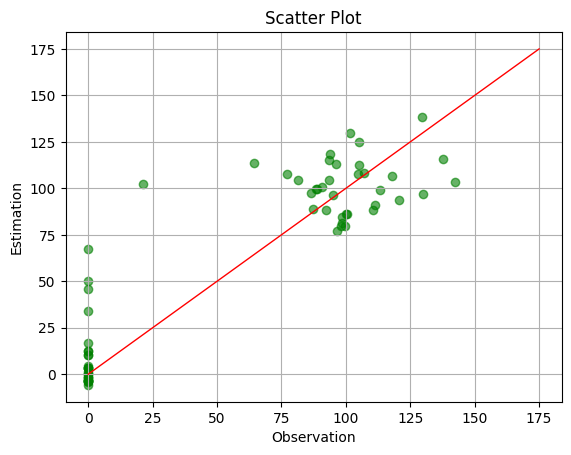

Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-train_EV01.png
Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-test_EV01.png

[第 2/5 次訓練]
▶ 以第 1, 3, 4, 5 場事件為訓練資料，以第 2 場事件為測試資料

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.1412 - val_loss: 0.0614
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0740 - val_loss: 0.0293
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0745 - val_loss: 0.0469
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0682 - val_loss: 0.0393
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0654 - val_loss: 0.0318
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0593 - val_loss: 0.0399
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0539 - val_loss: 0.0241
Epoch 8/100
16/16 [===================

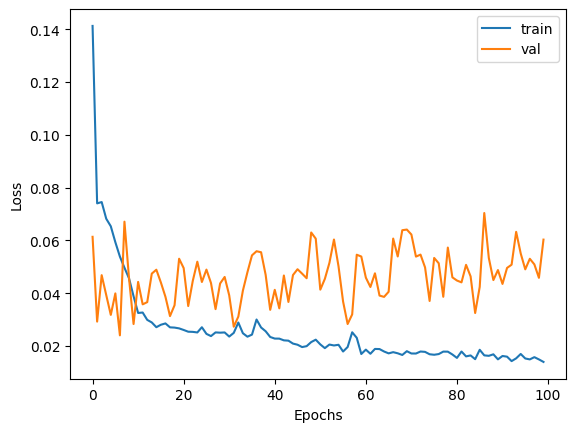

Training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/Weights_EV02.h5
2/2 [==============================] - 0s 3ms/step


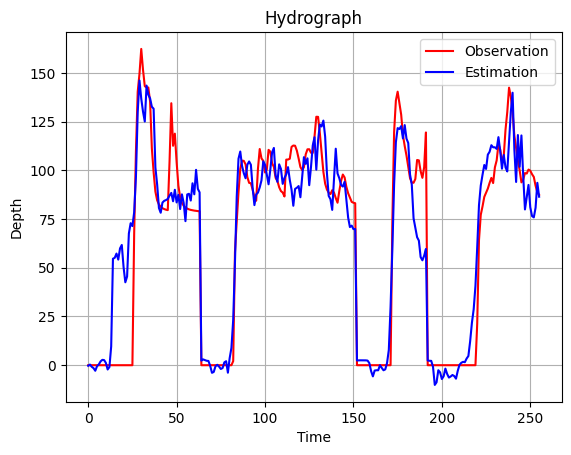

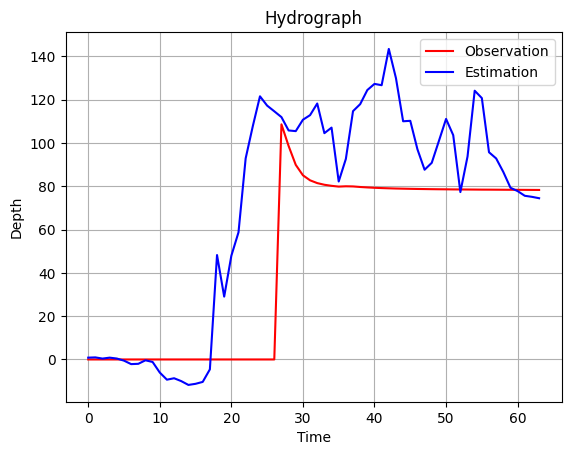

Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-train_EV02.png
Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-test_EV02.png


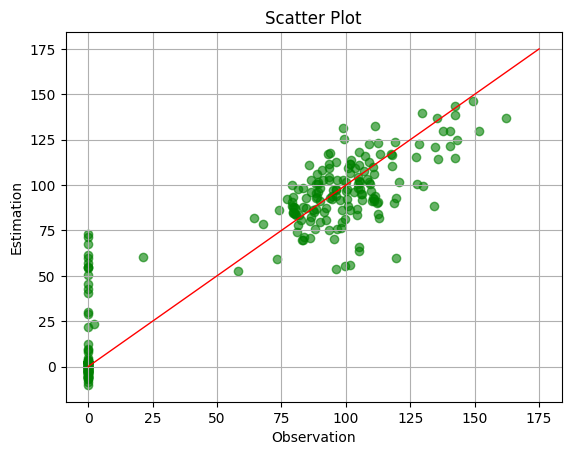

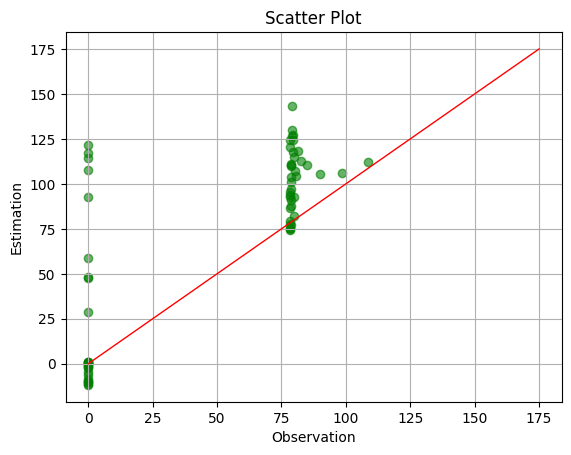

Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-train_EV02.png
Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-test_EV02.png

[第 3/5 次訓練]
▶ 以第 1, 2, 4, 5 場事件為訓練資料，以第 3 場事件為測試資料

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 0.1206 - val_loss: 0.1393
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0706 - val_loss: 0.0632
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0620 - val_loss: 0.1369
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0570 - val_loss: 0.0980
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0552 - val_loss: 0.1382
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0521 - val_loss: 0.0933
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0505 - val_loss: 0.0778
Epoch 8/100
16/16 [===================

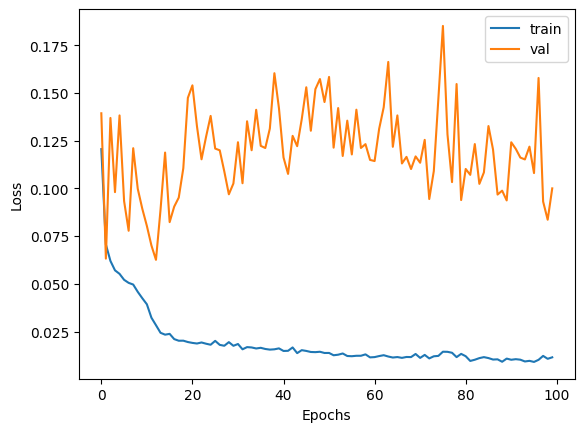

Training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/Weights_EV03.h5
2/2 [==============================] - 0s 10ms/step


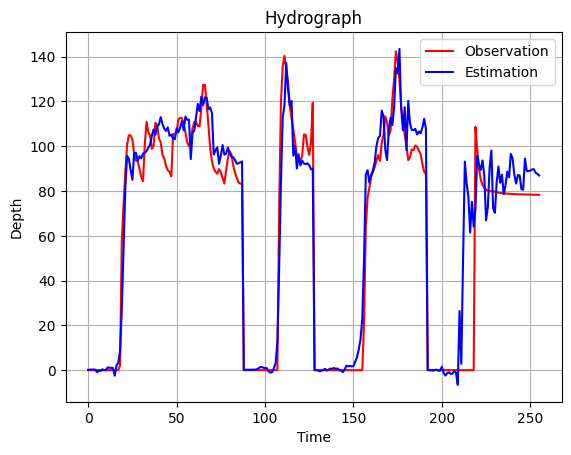

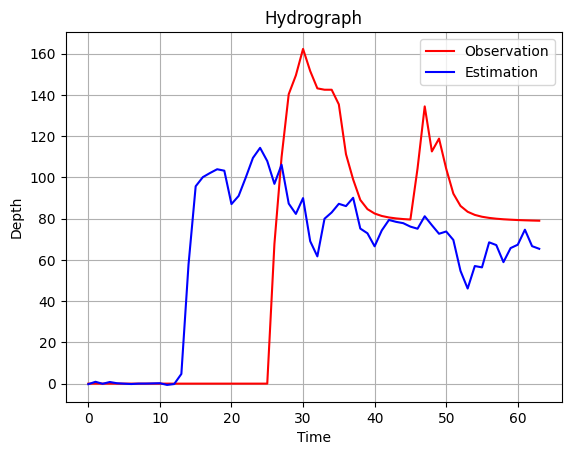

Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-train_EV03.png
Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-test_EV03.png


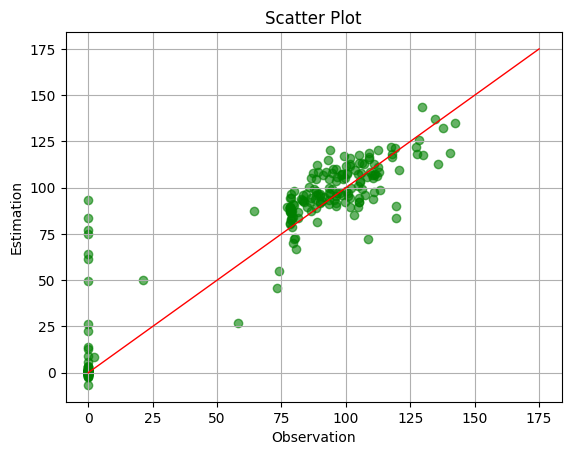

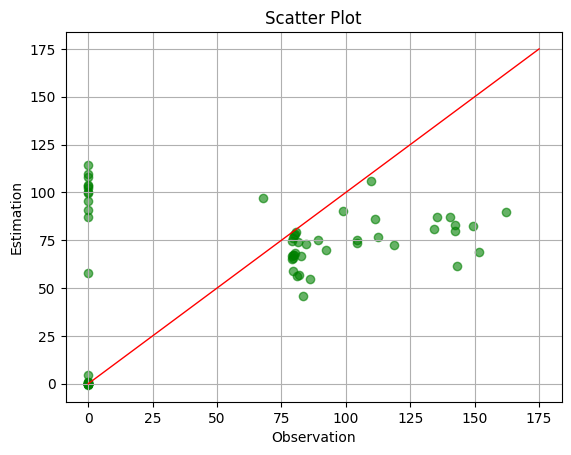

Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-train_EV03.png
Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-test_EV03.png

[第 4/5 次訓練]
▶ 以第 1, 2, 3, 5 場事件為訓練資料，以第 4 場事件為測試資料

Epoch 1/100
15/15 [==============================] - 1s 22ms/step - loss: 0.1229 - val_loss: 0.0627
Epoch 2/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0766 - val_loss: 0.0935
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0664 - val_loss: 0.0737
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0630 - val_loss: 0.0811
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0625 - val_loss: 0.0685
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0607 - val_loss: 0.0846
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.0797
Epoch 8/100
15/15 [===================

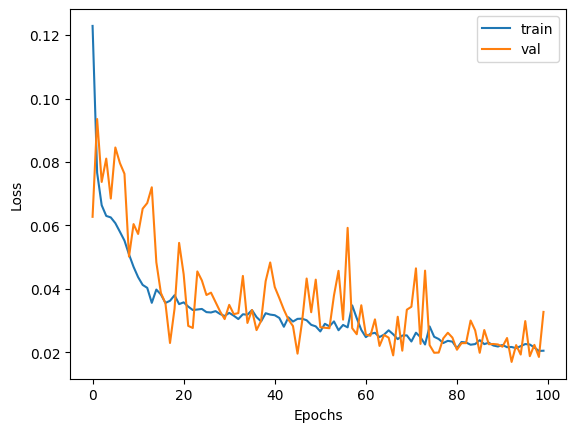

Training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/Weights_EV04.h5
3/3 [==============================] - 0s 30ms/step


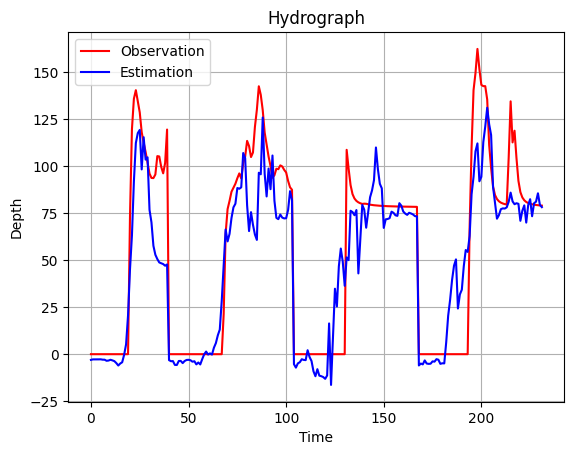

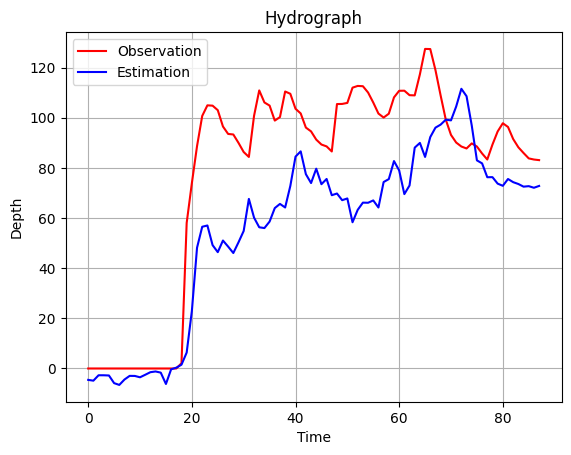

Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-train_EV04.png
Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-test_EV04.png


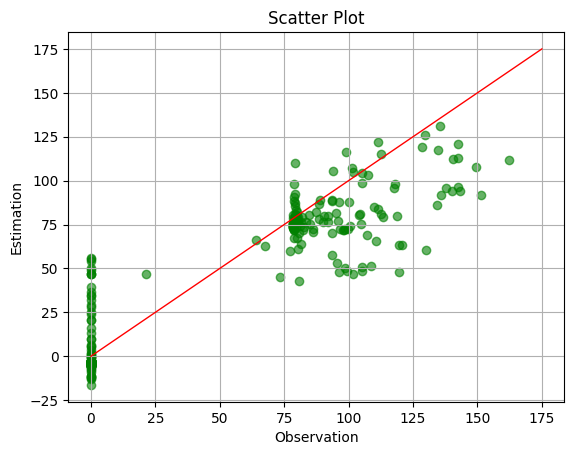

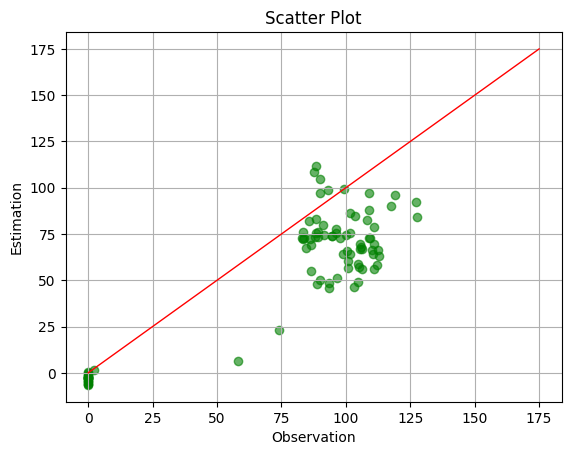

Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-train_EV04.png
Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-test_EV04.png

[第 5/5 次訓練]
▶ 以第 1, 2, 3, 4 場事件為訓練資料，以第 5 場事件為測試資料

Epoch 1/100
18/18 [==============================] - 1s 15ms/step - loss: 0.1148 - val_loss: 0.0965
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0638 - val_loss: 0.0974
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0597 - val_loss: 0.1086
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0550 - val_loss: 0.0849
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0540 - val_loss: 0.0955
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0500 - val_loss: 0.0851
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0455 - val_loss: 0.0631
Epoch 8/100
18/18 [===================

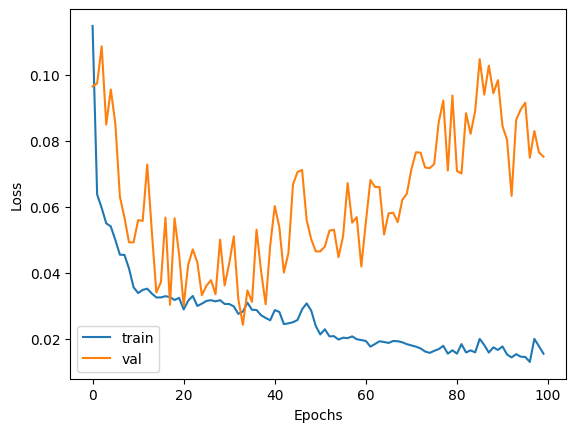

Training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/Weights_EV05.h5
2/2 [==============================] - 0s 9ms/step


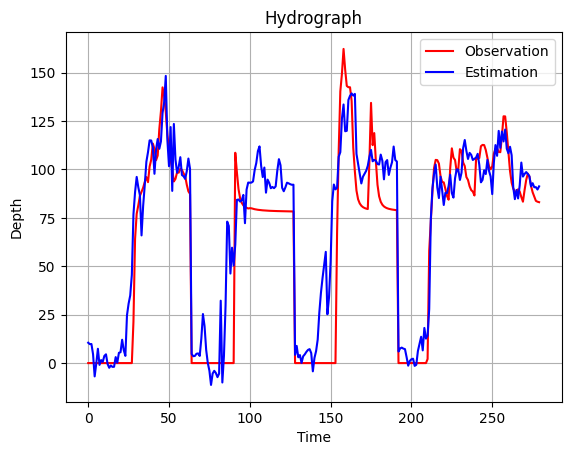

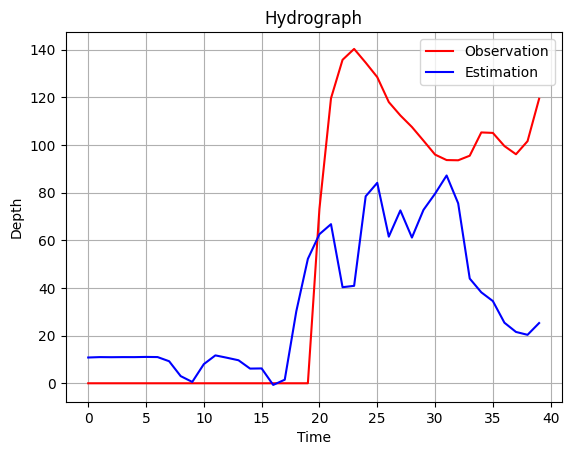

Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-train_EV05.png
Hydrograph saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Hydrographs/RES-test_EV05.png


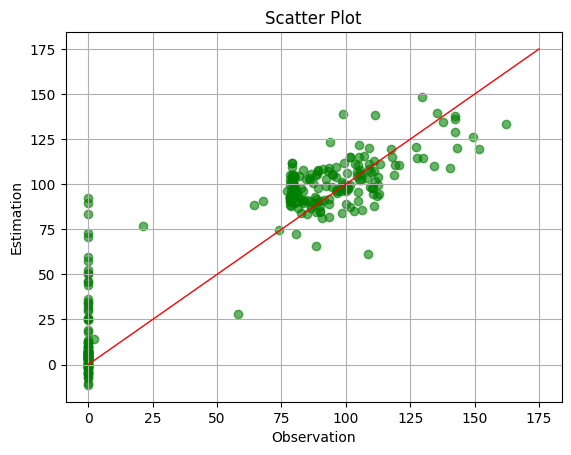

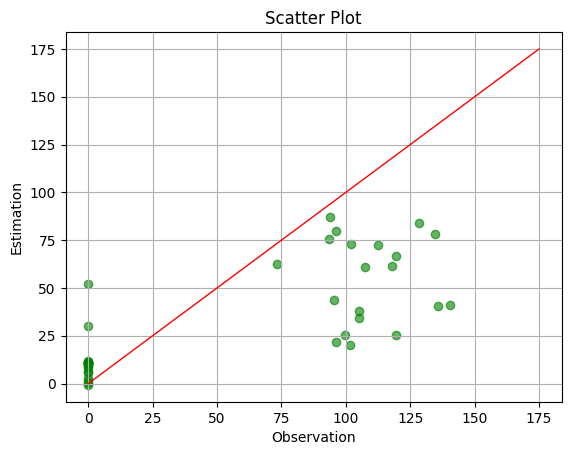

Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-train_EV05.png
Scatter plot saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/Scatter_Plots/RES-test_EV05.png


In [ ]:
# 交叉驗證(使不同事件輪流當測試資料)

for i in range(num_events):

  #***************************************************************************
  # 資料前處理
  #***************************************************************************
  events, event_order, boundary, split_boundary = reorder_events(events, event_order) # 整理輸入資料順序以便輸入模型
  event_orders.append(event_order) # 紀錄資料的順序  
  boundaries.append(boundary) # 紀錄資料長度的分割邊界 

  print('\n[第 %d/%d 次訓練]' %(i+1, num_events))
  print('▶ 以第 ' + (', '.join(str(x) for x in sorted(event_order[:-1]))) + ' 場事件為訓練資料，以第 ' + str(event_order[-1]) + ' 場事件為測試資料\n')

  # 產生輸入模型的資料
  X, Y = create_sequences(events) # 產生參考資料序列(X)及標籤資料序列(Y)
  nX, nY = normalize(X), normalize(Y) # 正規化
  X_train, Y_train, X_test, Y_test = split_data(nX, nY, split_boundary) # 分割訓練及測試資料
  steps, features = X_train.shape[1], X_train.shape[2]

  # 輸出的權重檔案名稱
  weights_name = 'Weights_EV' + "%02d" % (i+1)

  #***************************************************************************
  # 傳統方法
  #***************************************************************************
  #---------------------------------------------------------------------------
  # BPNN 
  #---------------------------------------------------------------------------
  # # 傳統方法的參考資料須調整資料維度
  # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
  # X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
  # # 創建模型
  # bpnn = My_BPNN()
  # # 訓練模型
  # W1, W2 = bpnn.train(X_train, Y_train)
  # # 預測
  # Y_train_predict = bpnn.predict(X_train, W1, W2)
  # Y_predict = bpnn.predict(X_test, W1, W2)

  #---------------------------------------------------------------------------
  # SVM
  #---------------------------------------------------------------------------
  # # 傳統方法的參考資料須調整資料維度
  # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
  # X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
  # # 創建模型
  # svm = My_SVM()
  # # 訓練模型
  # model = svm.create_model()
  # model = svm.train(model, X_train, Y_train)
  # # 預測
  # Y_train_predict = model.predict(X_train)
  # Y_predict = model.predict(X_test)

  #***************************************************************************
  # 新方法
  #***************************************************************************
  #---------------------------------------------------------------------------
  # CNN
  #---------------------------------------------------------------------------
  # 創建模型
  cnn = My_CNN()
  model = cnn.create_model(steps, features)
  # 訓練模型
  model = cnn.train(model, X_train, Y_train, X_test, Y_test)
  # 儲存模型
  path = WEIGHTS_FOLDER + weights_name + '.h5'
  model.save(path)
  print('Training weights saved in ' + path)
  # 預測
  Y_train_predict = model.predict(X_train) # 以訓練資料預測
  Y_predict = model.predict(X_test) # 以測試資料預測

  #---------------------------------------------------------------------------
  # LSTM
  #---------------------------------------------------------------------------
  # # 創建模型
  # lstm = My_LSTM()
  # model = lstm.create_model(steps, features)
  # # 訓練模型
  # model = lstm.train(model, X_train, Y_train, X_test, Y_test)
  # # 儲存模型
  # path = WEIGHTS_FOLDER + weights_name + '.h5'
  # model.save(path)
  # print('Training weights saved in ' + path)
  # # 預測
  # Y_train_predict = model.predict(X_train) # 以訓練資料預測
  # Y_predict = model.predict(X_test) # 以測試資料預測

  #---------------------------------------------------------------------------
  # GRU
  #---------------------------------------------------------------------------
  # # 創建模型
  # gru = My_GRU()
  # model = gru.create_model(steps, features)
  # # 訓練模型
  # model = gru.train(model, X_train, Y_train, X_test, Y_test)
  # # 儲存模型
  # path = WEIGHTS_FOLDER + weights_name + '.h5'
  # model.save(path)
  # print('Training weights saved in ' + path)
  # # 預測
  # Y_train_predict = model.predict(X_train) # 以訓練資料預測
  # Y_predict = model.predict(X_test) # 以測試資料預測

  #***************************************************************************
  # 資料後處理
  #***************************************************************************
  # 反正規化
  Y_train = denormalize(Y_train, Y) 
  Y_train_predict = denormalize(Y_train_predict, Y) 
  Y_test = denormalize(Y_test, Y) 
  Y_predict = denormalize(Y_predict, Y) 
  # 儲存預測結果
  RES_train.append([Y_train, Y_train_predict])
  RES_test.append([Y_test, Y_predict]) 

  #***************************************************************************
  # 畫圖
  #***************************************************************************
  # 創建歷線圖資料夾(如果資料夾不存在)
  if not os.path.exists(HYDROGRAPH_FOLDER):
    os.mkdir(HYDROGRAPH_FOLDER)
  # 創建散點圖資料夾(如果資料夾不存在)
  if not os.path.exists(SCATTER_PLOT_FOLDER):
    os.mkdir(SCATTER_PLOT_FOLDER)
  # 輸出的權重檔案名稱
  train_name = 'RES-train_EV' + "%02d" % (i+1)
  test_name = 'RES-test_EV' + "%02d" % (i+1)
  # 畫歷線圖
  fig_train = draw_hydrograph(Y_train, Y_train_predict) 
  fig_test = draw_hydrograph(Y_test, Y_predict) 
  # 儲存歷線圖
  train_path = HYDROGRAPH_FOLDER + train_name + '.png'
  test_path = HYDROGRAPH_FOLDER + test_name + '.png'
  fig_train.savefig(train_path)
  fig_test.savefig(test_path)
  print('Hydrograph saved in ' + train_path)
  print('Hydrograph saved in ' + test_path)
  # 畫散點圖
  fig_train = draw_scatter(Y_train, Y_train_predict) 
  fig_test = draw_scatter(Y_test, Y_predict) 
  # 儲存散點圖
  train_path = SCATTER_PLOT_FOLDER + train_name + '.png'
  test_path = SCATTER_PLOT_FOLDER + test_name + '.png'
  fig_train.savefig(train_path)
  fig_test.savefig(test_path)
  print('Scatter plot saved in ' + train_path)
  print('Scatter plot saved in ' + test_path)


###輸出結果 (寫入excel檔)

RES-train

In [ ]:
# 產生一個空的excel檔
wb = openpyxl.Workbook()
del wb['Sheet']

# 取得測試資料及預測資料的列表
all_trains = []
all_train_predicts = []
for i in range(len(RES_train)):
  all_trains.append(np.array(RES_train[i][0]).T.flatten().tolist()) # Observation
  all_train_predicts.append(np.array(RES_train[i][1]).T.flatten().tolist()) # Estimation

# 將所有資料取到小數點第二位
for i in range(len(all_trains)):
  for j in range(len(all_trains[i])):
    all_trains[i][j] = round(all_trains[i][j], 2)
    all_train_predicts[i][j] = round(all_train_predicts[i][j], 2)

# 計算表格數據(第一個工作表)
indexOfMaxVal = list(Y).index(np.max(Y)) # 計算 event with max value
for i in range(len(boundaries[0])):
  if indexOfMaxVal < boundaries[0][i]:
    eventWithMaxVal = i+1
    break

sheet = wb.create_sheet("Event Statistics")
sheet.append([ "Number of event (Nev)" ])
sheet.append([ num_events ])
sheet.append([ "Event with max value" ])
sheet.append([ eventWithMaxVal ]) 
sheet.append([ "Event", "number of data" ])
for i in range(num_events):
  sheet.append([i+1, len(events[i])])

# 將每個Event的預測結果分成不同工作表(第二個~倒數第二個工作表)
for i in range(num_events):
  sheet_name = "Event " + "%02d" %(i+1)
  sheet = wb.create_sheet(sheet_name)
  sheet.freeze_panes = "A2"
  sheet.append([ 'Observation', 'Estimation', 'Event', 'Tested Event' ])
  for j in range(len(all_trains[i])):
    for k in range(len(boundaries[i])):
      if j < boundaries[i][k]:
        event_num = event_orders[i][k] # 找出數據屬於哪個事件
        break
    sheet.append([ all_trains[i][j], all_train_predicts[i][j], event_num, event_orders[i][-1] ])

# 將所有預測結果存到同一個工作表(最後一個工作表)
sheet = wb.create_sheet("All Events")
sheet.freeze_panes = "A2"
sheet.append([ 'Observation', 'Estimation', 'Event', 'Tested Event' ])
for i in range(num_events):
  for j in range(len(all_trains[i])):
    for k in range(len(boundaries[i])):
      if j < boundaries[i][k]:
        event_num = event_orders[i][k] # 找出數據屬於哪個事件
        break
    sheet.append([ all_trains[i][j], all_train_predicts[i][j], event_num, event_orders[i][-1] ])

# 輸出excel檔
path = OUTPUT_FOLDER + 'RES-train.xlsx'
wb.save(path)
print("Result saved in " + path)


Result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/RES-train.xlsx


RES-test

In [ ]:
# 產生一個空的excel檔
wb = openpyxl.Workbook()
del wb['Sheet']

# 取得測試資料及預測資料的列表
all_tests = []
all_predicts = []
for i in range(len(RES_test)):
  all_tests.append(np.array(RES_test[i][0]).T.flatten().tolist()) # Observation
  all_predicts.append(np.array(RES_test[i][1]).T.flatten().tolist()) # Estimation

# 將所有資料取到小數點第二位
for i in range(len(all_tests)):
  for j in range(len(all_tests[i])):
    all_tests[i][j] = round(all_tests[i][j], 2)
    all_predicts[i][j] = round(all_predicts[i][j], 2)

# 計算表格數據(第一個工作表)
sheet = wb.create_sheet("Event Statistics")
sheet.append([ "Number of event (Nev)" ])
sheet.append([ num_events ])
sheet.append([ "Event with max value" ])
sheet.append([ eventWithMaxVal ]) 
sheet.append([ "Event", "number of data" ])
for i in range(num_events):
  sheet.append([i+1, len(events[i])])

# 將每個Event的預測結果分成不同工作表(第二個~倒數第二個工作表)
for i in range(num_events):
  sheet_name = "Event " + "%02d" %(i+1)
  sheet = wb.create_sheet(sheet_name)
  sheet.freeze_panes = "A2"
  sheet.append([ 'Observation', 'Estimation', 'Event' ])
  for j in range(len(all_tests[i])):
    sheet.append([ all_tests[i][j], all_predicts[i][j] , i+1 ])

# 將所有預測結果存到同一個工作表(最後一個工作表)
sheet = wb.create_sheet("All Events")
sheet.freeze_panes = "A2"
sheet.append([ 'Observation', 'Estimation', 'Event' ])
for i in range(num_events):
  for j in range(len(all_tests[i])):
    sheet.append([ all_tests[i][j], all_predicts[i][j], i+1 ])

# 輸出excel檔
path = OUTPUT_FOLDER + 'RES-test.xlsx'
wb.save(path)
print("Result saved in " + path)


Result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/RES-test.xlsx


Index

In [ ]:
# 載入RES資料
def load_RES(path):
  wb = openpyxl.load_workbook(path, data_only=True)
  data = {}
  for i in range(len(wb.sheetnames)):
    df = pd.DataFrame(get_values(wb[wb.sheetnames[i]]))
    df.columns = df.iloc[0]
    df = df.drop([0], axis=0)
    data[wb.sheetnames[i]] = df
  return data

# 要計算的指標
index_names = ['RMSE', 'MAE', 'CE', 'CC', 'EQp', 'ETp']

# 讀取資料
RES_train = load_RES(OUTPUT_FOLDER + 'RES-train.xlsx')
RES_test = load_RES(OUTPUT_FOLDER + 'RES-test.xlsx')

index_train = {}
index_test = {}

for i in range(num_events):
  event_train = "Event " + "%02d" %(i+1)
  event_test = "Event " + "%02d" %(i+1)

  # 取得訓練資料及測試資料的實際值(Observation)和預測值(Estimation)
  obv_train = np.array(RES_train[event_train]['Observation'], dtype=np.float64)
  est_train = np.array(RES_train[event_train]['Estimation'], dtype=np.float64)
  obv_test = np.array(RES_test[event_test]['Observation'], dtype=np.float64)
  est_test = np.array(RES_test[event_test]['Estimation'], dtype=np.float64)

  # 計算訓練資料的指標
  rmse_train = np.sqrt(np.mean((est_train - obv_train) ** 2))
  mae_train = np.mean(np.abs(est_train - obv_train))
  ce_train = 1 - np.sum((est_train - obv_train) ** 2) / np.sum((obv_train - np.mean(obv_train)) ** 2)
  cc_train = np.corrcoef(est_train, obv_train)[0, 1]
  eqp_train = (np.max(est_train) - np.max(obv_train)) / np.max(obv_train)
  etp_train = np.abs(np.argmax(est_train) - np.argmax(obv_train))

  # 計算測試資料的指標
  rmse_test = np.sqrt(np.mean((est_test - obv_test) ** 2))
  mae_test = np.mean(np.abs(est_test - obv_test))
  ce_test = 1 - np.sum((est_test - obv_test) ** 2) / np.sum((obv_test - np.mean(obv_test)) ** 2)
  cc_test = np.corrcoef(est_test, obv_test)[0, 1]
  eqp_test = (np.max(est_test) - np.max(obv_test)) / np.max(obv_test)
  etp_test = np.abs(np.argmax(est_test) - np.argmax(obv_test))

  # 儲存計算後的指標在字典中
  index_train[event_train] = {'RMSE':rmse_train, 'MAE':mae_train, 'CE':ce_train, 'CC':cc_train, 'EQp':eqp_train, 'ETp':etp_train}
  index_test[event_test] = {'RMSE':rmse_test, 'MAE':mae_test, 'CE':ce_test, 'CC':cc_test, 'EQp':eqp_test, 'ETp':etp_test}

print('Index train:\n', index_train)
print('Index test:\n', index_test)

# 將指標寫入excel檔
wb = openpyxl.Workbook()
del wb['Sheet']

# 計算表格數據(第一個工作表)
avg_index_train = {}
avg_index_test = {}

for index_name in index_names:
  total_train = []
  total_test = []
  for i in range(num_events):
    if i == eventWithMaxVal-1: 
      continue
    event_train = "Event " + "%02d" %(i+1)
    event_test = "Event " + "%02d" %(i+1)
    total_train.append(index_train[event_train][index_name])
    total_test.append(index_test[event_test][index_name])
  avg_index_train[index_name] = np.mean(total_train)
  avg_index_test[index_name] = np.mean(total_test)
  
print('Avg index train:\n', avg_index_train)
print('Avg index test:\n', avg_index_test)

sheet = wb.create_sheet("Event Statistics")
sheet.append([ "Event with max value" ])
sheet.append([ eventWithMaxVal ])
sheet.append([ '', 'Train', 'Test' ])
for index_name in index_names:
  sheet.append([ index_name, round(avg_index_train[index_name], 4), round(avg_index_test[index_name], 4) ])

# 將不同指標寫入不同工作表
for index_name in index_names:
  sheet = wb.create_sheet(index_name)
  sheet.append([ 'Event', 'Train', 'Test' ])
  for i in range(num_events):
    event_train = "Event " + "%02d" %(i+1)
    event_test = "Event " + "%02d" %(i+1)
    sheet.append([ i+1, round(index_train[event_train][index_name], 4), round(index_test[event_test][index_name], 4) ])

# 輸出excel檔
path = OUTPUT_FOLDER + 'Index.xlsx'
wb.save(path)
print("Result saved in " + path)


Index train:
 {'Event 01': {'RMSE': 22.096083274955088, 'MAE': 14.20078125, 'CE': 0.7933996288993632, 'CC': 0.8949919464855459, 'EQp': -0.15488443759630197, 'ETp': 5}, 'Event 02': {'RMSE': 18.913414283088866, 'MAE': 12.308984374999998, 'CE': 0.8610760487813713, 'CC': 0.9281832302771889, 'EQp': -0.09984591679506927, 'ETp': 1}, 'Event 03': {'RMSE': 15.561008387352345, 'MAE': 8.580078125, 'CE': 0.8953400030244041, 'CC': 0.9506443348383758, 'EQp': 0.00758480230353264, 'ETp': 2}, 'Event 04': {'RMSE': 22.914265480263598, 'MAE': 15.505905172413792, 'CE': 0.793665184693021, 'CC': 0.9051253623305897, 'EQp': -0.1926656394453004, 'ETp': 5}, 'Event 05': {'RMSE': 20.05128099755368, 'MAE': 13.628178571428569, 'CE': 0.827372205920295, 'CC': 0.9249483345447241, 'EQp': -0.08591679506933743, 'ETp': 110}}
Index test:
 {'Event 01': {'RMSE': 22.404663960602043, 'MAE': 15.559843749999999, 'CE': 0.8123696238274778, 'CC': 0.9066622190427673, 'EQp': -0.02830254933632961, 'ETp': 2}, 'Event 02': {'RMSE': 39.8492